In [2]:
import requests
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import time
import datetime
from datetime import datetime, date
from datetime import timedelta
import talib
import pickle
from scipy import stats
from datetime import datetime as dt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import Imputer, RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score,log_loss
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from xgboost import XGBClassifier
import lightgbm as lgb
from scipy.signal import argrelextrema

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [142]:
from_date = date(2013,1,1)
to_date=datetime.now()

start= time.mktime(from_date.timetuple())
end = time.mktime(to_date.timetuple())

tickers = ['USDT_BTC','USDT_ETC','USDT_EOS','USDT_XMR','USDT_ETH','USDT_DASH','USDT_BAT','USDT_GNT',
 'USDT_XRP','USDT_LTC','USDT_XLM','USDT_REP','USDT_ZEC','USDT_IOT','USDT_NEO','USDT_BCH','USDT_TRX','USDT_OMG',
           'USDT_XTZ','USDT_BSV','USDT_MKR','USDT_ZRX','USDT_VET','USDT_BTG','USDT_ZIL']#bitfinex

def get_data(date,coin):
    """ Query the API for 2000 days historical price data starting from "date". """
    url = "https://min-api.cryptocompare.com/data/histohour?fsym="+coin+"&tsym=USD&limit=1000&toTs={}".format(date)
    r = requests.get(url)
    ipdata = r.json()
    return ipdata

def get_hourly(date,coin, exchange=''):
    url = 'https://min-api.cryptocompare.com/data/histohour?fsym='+coin+'&tsym=USD&limit=999&toTs={}'\
            .format(date)
    if exchange:
        url += '&e={}'.format(exchange)
    page = requests.get(url)
    data = page.json()#['Data']
    #df = pd.DataFrame(data)
    #df['timestamp'] = [datetime.fromtimestamp(d) for d in df.time]
    return data


def get_df(from_date, to_date,coin):
    date = to_date
    holder = []
    # While the earliest date returned is later than the earliest date requested, keep on querying the API
    # and adding the results to a list. 
    while date > from_date:
        data = get_hourly(date,coin,exchange='Bitfinex')
        holder.append(pd.DataFrame(data['Data']))
        date = data['TimeFrom']
    # Join together all of the API queries in the list.    
    df = pd.concat(holder, axis = 0)                    
    # Remove data points from before from_date
    df = df[df['time']>from_date]                       
    # Convert to timestamp to readable date format
    df['time'] = pd.to_datetime(df['time'], unit='s')   
    # Make the DataFrame index the time
    df.set_index('time', inplace=True)                  
    # And sort it so its in time order 
    df.sort_index(ascending=True, inplace=True)
    df.to_csv("1h_"+coin + '.csv')
    print('Processed: ' + coin)
    return df

def coin_metrics(cap,coin,start,end):#used to get market cap and total volume
    if cap=='cap':
        url='https://coinmetrics.io/api/v1/get_asset_data_for_time_range/'+coin+'/marketcap(usd)/'+str(start)+'/'+str(end)
    else:
        url='https://coinmetrics.io/api/v1/get_asset_data_for_time_range/'+coin+'/exchangevolume(usd)/'+str(start)+'/'+str(end)

    r=requests.get(url)
    ipdata = r.json()
    ipdata['result']
    cap=pd.DataFrame(ipdata['result'],columns=['date','cap'])
    date=[]
    for i in cap.date:
        date.append(pd.to_datetime(datetime.fromtimestamp(i)))
    cap.index=date
    cap=cap.resample('1H').ffill()
    return cap['cap']

for x in tickers:
    get_df(start,end,x[5:])
    

Processed: BTC
Processed: ETC
Processed: EOS
Processed: XMR
Processed: ETH
Processed: DASH
Processed: BAT
Processed: GNT
Processed: XRP
Processed: LTC
Processed: XLM
Processed: REP
Processed: ZEC
Processed: IOT
Processed: NEO
Processed: BCH
Processed: TRX
Processed: OMG
Processed: XTZ
Processed: BSV
Processed: MKR
Processed: ZRX
Processed: VET
Processed: BTG
Processed: ZIL


In [204]:
def divergence(close,RSI,lookback,window,maxx,low):
    x=RSI.values
    peaks=argrelextrema(x, np.greater,order=5)[0]
    troughs=argrelextrema(x, np.less,order=5)[0]
    bear_rsi=[]
    bear_price=[]
    bull_rsi=[]
    bull_price=[]
    for x in peaks:    
        if RSI.iloc[x]>maxx:
            if RSI.iloc[x]<max(RSI.iloc[max(0,x-lookback):x]):
                bear_rsi.append(x)
            if close.iloc[x]>max(close.iloc[max(0,x-lookback):x]):
                bear_price.append(x)
    
    for t in troughs:
        if RSI.iloc[t]<low:
            if close.iloc[t]<min(close.iloc[max(0,t-lookback):t]):
                bull_price.append(t)
    
    for z in range(1,len(troughs)):
        if RSI.iloc[troughs[z]]<low:
            if RSI.iloc[troughs[z]]>RSI.iloc[troughs[z-1]]:
                bull_rsi.append(troughs[z])  
            
    dt=set(bear_rsi)
    dt2=set(bear_price)
    dt3=set(bull_rsi)
    dt4=set(bull_price)
    mergedlist=dt.intersection(dt2)
    mergedlist=np.array(list(mergedlist))
    mergedlist2=dt3.intersection(dt4)
    mergedlist2=np.array(list(mergedlist2))
    bull_div=np.sort(mergedlist2)
    bear_div=np.sort(mergedlist)
    return bull_div,bear_div

def bbp(price):
    up, mid, low = talib.BBANDS(price, timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
    bbp = (price - low) / (up - low)
    return bbp

In [205]:

def retrieve_symbol_name(coin,window):
    col=['date','close']
    ndf=pd.read_csv("1h_"+coin+'.csv',index_col='time')
    ndf.index=pd.to_datetime(ndf.index)
    ndf=ndf.loc[(ndf!=0).any(axis=1)]
    ndf=ndf.drop(["volumefrom"],axis=1)
    
    df=pd.DataFrame()
    unique_dates=ndf.index.drop_duplicates(keep='first')
    for i in unique_dates:
        if len(ndf.loc[i])>2:
            df=df.append(ndf.loc[i])
        else:
            df=df.append(ndf.loc[i].iloc[1,:])
    df['returns']=df['close'].pct_change()
    df['coin']=coin
    df['RSI']=talib.RSI(df['close'], timeperiod=window)
    df['RSI_10']=df['RSI'].rolling(10).mean()
    df['RSI_50']=df['RSI'].rolling(50).mean()
    df['RSI_up']= (df['RSI_10']> df['RSI_50']).astype(float)
    div=divergence(df['close'],df['RSI'],24*4,window,70,40)
    df['bull_div']=0
    df['bull_div'].iloc[div[0]]=1
    df['bear_div']=0
    df['bear_div'].iloc[div[1]]=1
    #df['hid_bull_div']=0
    #df['hid_bull_div'].iloc[div[2]]=1
    #df['hid_bear_div']=0
    #df['hid_bear_div'].iloc[div[3]]=1
    df['10_MA']=df['close'].rolling(10).mean()
    df['50_MA']=df['close'].rolling(50).mean()
    df['MA_up']= (df['10_MA']> df['50_MA']).astype(float)
    df['volume_10']=df['volumeto'].rolling(10).mean()
    df['volume_50']=df['volumeto'].rolling(50).mean()
    df['vol_up']= (df['volume_10']> df['volume_50']).astype(float)
    df['var']=df['returns'].rolling(50).var()
    df['50_var']=df['var'].rolling(50).mean()
    df['200_var']=df['var'].rolling(200).mean()
    df['1000_var']=df['var'].rolling(1000).mean()
    df['var_up_short']= (df['50_var']> df['200_var']).astype(float)
    df['var_up_long']= (df['200_var']> df['1000_var']).astype(float)
    close = df['close']
    high = df['high']
    low = df['low']
    df['ATR'] = talib.ATR(high, low, close, window)
    df['50_Std']=df['returns'].rolling(50).std()
    df['rise']=(df['returns']>2*df['50_Std']).astype(float)
    df['fall']=(df['returns']<-2*df['50_Std']).astype(float)
    df['rise2']=(df['returns']>3.5*df['50_Std']).astype(float)
    df['fall2']=(df['returns']<-3.5*df['50_Std']).astype(float)
    df['ADX'] = talib.ADX(high, low, close, window)
    macd, macdsignal, macdhist = talib.MACD(df['close'], fastperiod=12, slowperiod=26, signalperiod=9)
    df['MACD']=macd
    df['MACD_Hist']=macdhist
    df['MACD_Signal']=macdsignal
    df['MACD_Hist_change']= df['MACD_Hist'].pct_change()
    df['Hist_std']=df['MACD_Hist_change'].rolling(50).std()
    df['MACD_signal']=(df['MACD_Hist_change']>df['Hist_std']).astype(float)
    df['Mom'] = talib.MOM(close, timeperiod=window)
    slowk, slowd = talib.STOCH(high, low, close, fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
    df['Stoch_k']=slowk
    df['Stoch_d']=slowd
    df['BB']=bbp(close)
    
    df.index=pd.to_datetime(df.index)
    from_date = (df.index[0]-timedelta(hours=24))
    to_date=df.index[-1]
    start= int(time.mktime(from_date.timetuple()))
    end = int(time.mktime(to_date.timetuple()))
    try:
        cap=coin_metrics('cap',coin.lower(),start,end)
        cap=cap[cap.index>df.index[0]]
        vol=coin_metrics('vol',coin.lower(),start,end)
        vol=vol[vol.index>df.index[0]]
    except:
        cap=0
        vol=0
    df['Market_Cap']=cap
    df['Total_vol']=vol
    df['vol/cap']=df['volumeto']/df['Market_Cap']
    df['Total_vol/cap']=df['Total_vol']/df['Market_Cap']
    df=df.dropna()
    hour=[]
    for i in df.index:
        hour.append(int(str(i)[11:13]))
    df['hour']=hour
    df['1_day_high']=df['high'].rolling(24).max()
    df['1_day_low']=df['low'].rolling(24).min()
    low=[]
    maxx=[]
    date=[]
    exit=[]
    errors=[]
    for i in df.index:
        if i+timedelta(hours=24) < df.index[-1]:
            try:
                low.append(df['1_day_low'].loc[i+timedelta(hours=24)])
                maxx.append(df['1_day_high'].loc[i+timedelta(hours=24)])
                date.append(i)
                exit.append(df['close'].loc[i+timedelta(hours=24)])
            except:
                try:
                    low.append(df['1_day_low'].loc[i+timedelta(hours=23)])
                    maxx.append(df['1_day_high'].loc[i+timedelta(hours=23)])
                    date.append(i)
                    exit.append(df['close'].loc[i+timedelta(hours=23)])
                except:
                    try:
                        low.append(df['1_day_low'].loc[i+timedelta(hours=22)])
                        maxx.append(df['1_day_high'].loc[i+timedelta(hours=22)])
                        date.append(i)
                        exit.append(df['close'].loc[i+timedelta(hours=22)])
                    except:
                        low.append(0)
                        maxx.append(0)
                        date.append(i)
                        errors.append(i)
                        exit.append(0)
                                    
    df2=[date,maxx,low,exit]
    df2=pd.DataFrame(df2)
    df2=df2.transpose()
    df2.columns=['date','1day_high','1day_low','exit']
    df2.index=df2['date']
    df2=df2.drop(['date'],axis=1)
    df=df.dropna()
    merged=df2.join(df,how='outer')
    merged=merged.dropna()
    merged=merged.drop(['1_day_high','1_day_low'],axis=1)
    merged['Pnl_Long']=((merged['exit']-merged['close'])/merged['close'])*100
    merged['Pnl_Short']=((-merged['exit']+merged['close'])/merged['close'])*100
    
    merged['exit']=pd.to_numeric(merged['exit'])
    merged['1day_high']=pd.to_numeric(merged['1day_high'])
    merged['1day_low']=pd.to_numeric(merged['1day_low'])
    merged['Pnl_Long']=pd.to_numeric(merged['Pnl_Long'])
    merged['Pnl_Short']=pd.to_numeric(merged['Pnl_Short'])
    merged=merged[merged['exit']>0]
    return merged

def all_coins():
    start=time.time()
    df=retrieve_symbol_name('BTC',14)
    for x in tickers[1:]:
        print(x)
        df=df.append(retrieve_symbol_name(x[5:],14))
    df=df.sort_index()
    print ("Runtime is " +str(time.time()-start)+" seconds")
    return df

df=all_coins()

#pickle the dataframe
filename = '1hr_df'
outfile = open(filename,'wb')
pickle.dump(df,outfile)
outfile.close()



/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/scipy/signal/_peak_finding.py:73: RuntimeWarning: invalid value encountered in greater
  results &= comparator(main, plus)
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/scipy/signal/_peak_finding.py:74: RuntimeWarning: invalid value encountered in greater
  results &= comparator(main, minus)
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/scipy/signal/_peak_finding.py:73: RuntimeWarning: invalid value encountered in less
  results &= comparator(main, plus)
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/scipy/signal/_peak_finding.py:74: RuntimeWarning: invalid value encountered in less
  results &= comparator(main, minus)
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/pandas/core/indexing.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.or

USDT_ETC
USDT_EOS
USDT_XMR
USDT_ETH
USDT_DASH
USDT_BAT
USDT_GNT
USDT_XRP
USDT_LTC
USDT_XLM
USDT_REP
USDT_ZEC
USDT_IOT
USDT_NEO
USDT_BCH
USDT_TRX
USDT_OMG
USDT_XTZ
USDT_BSV
USDT_MKR
USDT_ZRX
USDT_VET
USDT_BTG
USDT_ZIL
Runtime is 1014.5643117427826 seconds


In [146]:
#load dataframe
filename = '1hr_df'
infile = open(filename,'rb')
df = pickle.load(infile)
infile.close()
df=df.drop_duplicates()

In [206]:
def week_start(df):#filter index for sundays at 00am
    dayofweek = df.index.dayofweek
    hour = df.index.hour
    x=df.iloc[((dayofweek == 6) & (hour == 0))]
    return x.index


def weekly_momentum(df):#calculate weekly price and volume momentum
    n=(week_start(df)[-1]-week_start(df)[0])/7#number of weeks in dataframe
    n=n.days
    pmom = pd.DataFrame(0, index=np.arange(n), columns=df['coin'].unique())
    vmom= pd.DataFrame(0, index=np.arange(n), columns=df['coin'].unique())    
    date=week_start(df)[0]
    
    dates=[]
    for i in range(0,n,1):
        cur=df.loc[date+timedelta(hours=i*24*7)]#fut is prices one week after to cur
        fut=df.loc[date+timedelta(hours=i*24*7+7*24)]
        dates.append(date+timedelta(hours=i*24*7+7*24))
        for coin in cur['coin']:
            if len(fut[fut['coin']==coin]['close'])>0:
                pmom[coin].iloc[i]=(fut[fut['coin']==coin]['close'][0]-cur[cur['coin']==coin]['close'][0])/cur[cur['coin']==coin]['close'][0]
                vmom[coin].iloc[i]=(fut[fut['coin']==coin]['volumeto'][0]-cur[cur['coin']==coin]['volumeto'][0])/cur[cur['coin']==coin]['volumeto'][0]

    pmom.index=dates
    vmom.index=dates
    return pmom,vmom


def rank(mom,df):#rank each coin and assign 1,-1 to top and bottom performers
    n=(week_start(df)[-1]-week_start(df)[0])/7
    n=n.days
    pmom = pd.DataFrame(0, index=np.arange(n), columns=mom.columns)
    for i in range(n):
        row=mom.iloc[i,:].copy()
        row=row[abs(row)>0].sort_values(ascending=False)
        if len(row)<7:
            pmom.loc[i,row.index[0]]=1
            pmom.loc[i,row.index[-1]]=-1
        if len(row)>=7 and len(row)<15:
            pmom.loc[i,list(row.index[0:2])]=1
            pmom.loc[i,list(row.index[-2:])]=-1
        if len(row)>=15:
            pmom.loc[i,list(row.index[0:3])]=1
            pmom.loc[i,list(row.index[-3:])]=-1
    pmom.index=mom.index
    return pmom   

def assign_mom(df,p_rnk,v_rnk):#create two new columns in our existing df where each coin is assigned 1,0,-1 depending on their momentum. 
    df1=df.copy()
    df1['pmom']=0
    df1['vmom']=0
    for coin in df1.coin.unique():
        df1.loc[df1['coin']==coin,'pmom']=p_rnk[coin]
        df1.loc[df1['coin']==coin,'vmom']=v_rnk[coin]
    df1.fillna(0,inplace=True)
    return df1


mom=weekly_momentum(df)
df=assign_mom(df,rank(mom[0],df),rank(mom[1],df))


/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/pandas/core/indexing.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in double_scalars
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in double_scalars


In [224]:
def entry_filter_long(df):
    df3=df.loc[(df['RSI_up']<1)].copy()# basic entry signal
    df3['max_return']=(df3['1day_high']-df3['close'])/df3['close']
    df3['label']=(df3['max_return']>0.05).astype(int)#trying to identify trades who have bigger potential
    return df3

def entry_filter_short(df):
    df3=df.loc[(df['BB']>.7)].copy()
    df3['max_return']=(df3['close']-df3['1day_low'])/df3['close']
    df3['label']=(df3['max_return']>0.05).astype(int)
    return df3

entry=entry_filter_long(df)


features=df.columns[3:]
features=list(features)
x=['coin','Pnl_Long','Pnl_Short']
features=[e for e in features if e not in x]


print('Percent of Target Trades:', 100*(entry.label.sum()) / float(len(entry)))
len(entry)

Percent of Target Trades: 32.6530612244898


161896

In [209]:
def max_draw(date,coin,df):#
    dates=[]
    perf=[]
    price=[]
    drawdowns=[perf]
    df=df[df['coin']==coin]
    for h in range(1,24):
        if date+timedelta(hours=24) < df.index[-1]:
            perf.append((df.low.loc[date+timedelta(hours=h)]-df.close.loc[date])/df.close.loc[date])
            dates.append(date+timedelta(hours=h))
            
    drawdowns=pd.DataFrame(drawdowns)
    drawdowns=drawdowns.transpose()
    drawdowns.index=dates
  
    return drawdowns.min()



In [ ]:
#loop through each trade in entry datframe and calculate the worse drawdown over 24hr
max_draws=[]
start=time.time()
for i in range(len(entry)):
    max_draws.append(max_draw(entry.index[i],entry['coin'][i],df)[0])
print ("Runtime is " +str(time.time()-start)+" seconds")

In [ ]:
entry['max_draw']=max_draws#add the max drawdown column to our entry dataframe
#pickle entry
filename = 'entry_draw'
outfile = open(filename,'wb')
pickle.dump(entry,outfile)
outfile.close()
entry.tail()

In [161]:
#load entry 
filename = 'entry_draw'
infile = open(filename,'rb')
entry = pickle.load(infile)
infile.close()


In [862]:
custom=entry.copy()
custom['max_draw']=custom['max_draw']*100

def stop_loss(entry_real,loss):
    entry=entry_real.copy()
    entry=entry.dropna()
    pnl=[]
    for i in range(len(entry)):
        if entry['max_draw'].iloc[i]<-loss:
            pnl.append(-loss)
        else:
            pnl.append(entry['Pnl_Long'].iloc[i])
    entry_real['Pnl_Long'].iloc[:len(pnl)]=pnl
    return entry_real

entry=stop_loss(custom,5)#filters the entry dataframe, depending on max drawdowns


/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/pandas/core/indexing.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [225]:

### Split the data into training, testing sets
train = entry[(pd.to_datetime(entry.index) < pd.to_datetime('2018-12-01')) & 
           (pd.to_datetime(entry.index) >= pd.to_datetime('2013-01-01'))]
test = entry[pd.to_datetime(entry.index) >= pd.to_datetime('2018-12-01')]
X_train = train.loc[:,features]
y_train = train.loc[:,'label']
X_test = test.loc[:,features]
y_test = test.loc[:,'label']

X = entry.loc[:,features]
Y=entry.loc[:,'label']

print('Length of Training Set: ' + str(len(train)))
print('Length of Testing Set: ' + str(len(test)))
    


Length of Training Set: 127229
Length of Testing Set: 34667


In [181]:
#optimise hyperparameters, choose set with lowest log_loss
log_losses={}

for n in range(100,400,100):
    for md in range(1,7):
        for mln in range(50,400,100):
            for nl in range(10,20,10):
                for lr in frange(.01,.2,.05):
                    param = {'max_depth':md, 'num_leaves':nl, 'learning_rate':lr, 'num_trees':n,'num_threads':-1,
         'min_data_in_leaf':mln, 'objective':'binary', 'metric':'binary_logloss','verbosity':-1}
                    data = lgb.Dataset(X_train, y_train)
                    bst=lgb.train(param, data)
                    y_pred=bst.predict(X_test)
                    sc=log_loss(y_test,y_pred)
                    log_losses[str(n)+'_'+str(md)+'_'+str(mln)+'_'+str(nl)+'_'+str(lr)]=sc
                    
                        

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


In [182]:
def optimal_param(data):
    df=pd.DataFrame.from_dict(data,orient='index')
    df.columns=['score']
    df=df.reset_index()
    split = df["index"].str.split("_", n = 4, expand = True) 
    df=df.join(split,how='outer')
    df=df.iloc[:,1:]
    df.columns=['score','num_trees','max_depth','min_leaf_data','num_leaves','learning_rate']
    for i in range(1,6):
        df.iloc[:,i]=pd.to_numeric(df.iloc[:,i])
    df=df.round(4)
    df=df.sort_values(by=['score'])
    return df

opt=optimal_param(log_losses)
#pickle the parameters 
filename = 'opt_param'
outfile = open(filename,'wb')
pickle.dump(opt,outfile)
outfile.close()
opt.head()


,score,num_trees,max_depth,min_leaf_data,num_leaves,learning_rate
45,0.5163,100,3,350,10,0.06
22,0.5169,100,2,150,10,0.11
23,0.5170,100,2,150,10,0.16
26,0.5173,100,2,250,10,0.11
27,0.5173,100,2,250,10,0.16


In [25]:
#load optimal long parameters
filename = 'opt_param'
infile = open(filename,'rb')
opt = pickle.load(infile)
infile.close()
opt.head()

EOFError: Ran out of input

In [170]:
opt_short=optimal_param(log_losses)
#pickle the parameters 
filename = 'opt_param_short'
outfile = open(filename,'wb')
pickle.dump(opt_short,outfile)
outfile.close()
opt_short.head()

,score,num_trees,max_depth,min_leaf_data,num_leaves,learning_rate
18,0.5246,100,2,50,10,0.11
33,0.5248,100,3,50,10,0.06
113,0.5252,200,2,50,10,0.06
117,0.5254,200,2,150,10,0.06
34,0.5256,100,3,50,10,0.11


In [34]:
#load optimal short parameters
filename = 'opt_param_short'
infile = open(filename,'rb')
opt_short = pickle.load(infile)
infile.close()
opt_short.head()

,score,num_trees,max_depth,min_leaf_data,num_leaves,learning_rate
73,0.5174,100,5,250,10,0.06
61,0.5174,100,4,350,10,0.06
89,0.5182,100,6,250,10,0.06
85,0.5183,100,6,150,10,0.06
93,0.5183,100,6,350,10,0.06


In [226]:
def xgb(long,test):
    n=0
    data = lgb.Dataset(X_train, y_train)
    if long==True:
        param = {'max_depth':opt['max_depth'].iloc[n], 'num_leaves':opt['num_leaves'].iloc[n], 'learning_rate':opt['learning_rate'].iloc[n], 'num_trees':opt['num_trees'].iloc[n],'num_threads':-1,
                 'min_data_in_leaf':opt['min_leaf_data'].iloc[n], 'objective':'binary', 'metric':'binary_logloss','verbosity':-1}
    else:
        param = {'max_depth':opt_short['max_depth'].iloc[n], 'num_leaves':opt_short['num_leaves'].iloc[n], 'learning_rate':opt_short['learning_rate'].iloc[n], 'num_trees':opt_short['num_trees'].iloc[n],'num_threads':-1,
                 'min_data_in_leaf':opt_short['min_leaf_data'].iloc[n], 'objective':'binary', 'metric':'binary_logloss','verbosity':-1}
    
    bst = lgb.train(param, data)
    y_pred = bst.predict(X_test)
    
    trades = test.assign(pred = y_pred)
    trades = trades[trades.pred >0.5]
    if long==True:
        trades['cpl'] = trades.Pnl_Long.cumsum()
        test['cpl'] = test.Pnl_Long.cumsum()
        #pickle the decision rules
        filename = 'xg_boost_long'
        outfile = open(filename,'wb')
        pickle.dump(bst,outfile)
        outfile.close()

    
    else:
        trades['cpl'] = trades.Pnl_Short.cumsum()
        test['cpl'] = test.Pnl_Short.cumsum()
        #pickle the decision rules
        filename = 'xg_boost_short'
        outfile = open(filename,'wb')
        pickle.dump(bst,outfile)
        outfile.close()
    return test,trades
    

test=xgb(True,test)[0]
trades=xgb(True,test)[1]


'Predicted trades '+str((y_pred.sum())/len(test))+'  :  Actual trades '+str((test.label.sum())/len(test))

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


'Predicted trades 0.3351080688678282  :  Actual trades 0.30908356650416824'

In [227]:
trades.pred.max()

0.9339022491068485

In [229]:
def drawdowns(equity_curve):
    # Calculate the cumulative returns curve 
    # and set up the High Water Mark
    # Then create the drawdown and duration series
    hwm = [0]
    eq_idx = equity_curve.index
    drawdown = pd.Series(index = eq_idx)
    duration = pd.Series(index = eq_idx)

    # Loop over the index range
    for t in range(1, len(eq_idx)):
        cur_hwm = max(hwm[t-1], equity_curve[t])
        hwm.append(cur_hwm)
        drawdown[t]= hwm[t] - equity_curve[t]
        duration[t]= 0 if drawdown[t] == 0 else duration[t-1] + 1
    return drawdown.max()#, duration

def stats_v2(trades,y_pred,prob):
    trades = test.assign(pred = y_pred)
    trades = trades[trades.pred>prob]
    col=['Mean_Return','Std','Count','Total','Sharpe']
    df=[trades.Pnl.mean(),trades.Pnl.std(),len(trades),trades.Pnl.sum(),trades.Pnl.mean()/trades.Pnl.std()]
    df=pd.DataFrame(df)
    df=df.transpose()
    df.columns=col
    return df

def stats(trades,test,y_pred,prob,t,direction):
    #trades = test.assign(pred = y_pred)
    trades = trades[trades.pred>prob]
    if direction=='long':
        ret=trades.Pnl_Long
        bench=test.Pnl_Long
    else:
        ret=trades.Pnl_Short
        bench=test.Pnl_Short
    
    neg1=bench[bench<0]
    neg=ret[ret<0]
    col=['Mean_Return','Std','Count','Total','Sharpe','Sortino','Calmar','1day_Calmar']
    df=[ret.mean(),ret.std(),len(trades),ret.sum(),ret.mean()/ret.std(),ret.mean()/neg.std(),trades.cpl.max()/drawdowns(trades.cpl),ret.mean()/abs(ret.min())]
    df1=[bench.mean(),bench.std(),len(test),bench.sum(),bench.mean()/bench.std(),ret.mean()/neg1.std(),test.cpl.max()/drawdowns(test.cpl),bench.mean()/abs(bench.min())]
    df1=pd.DataFrame(df1)
    df1=df1.transpose()
    df1.columns=col
    df=pd.DataFrame(df)
    df=df.transpose()
    df.columns=col
    if t=='base':
        df=df.append(df1)
        df.index=['ML','Basic']
    return df

def frange(x, y, jump):
    while x < y:
        yield x
        x += jump

def opt_prob(direction):
    p=.5
    prob=[p]
    df=stats(trades,test,y_pred,p,'t',direction)  
    for x in frange(.55,trades.pred.max(),.05):
        try:
            df=df.append(stats(trades,test,y_pred,x,'t',direction))
            prob.append(x)
        except:
            break
            
    df.index=prob
    return df


res=opt_prob('long')
res


,Mean_Return,Std,Count,Total,Sharpe,Sortino,Calmar,1day_Calmar
0.50,1.057185,7.988072,6780.0,7167.715833,0.132345,0.234579,1.784444,0.040071
0.55,1.165007,8.394039,4888.0,5694.553886,0.138790,0.251008,1.784444,0.045752
0.60,1.513516,8.773118,2993.0,4529.954485,0.172517,0.318340,1.784444,0.063967
0.65,2.598827,9.632791,1512.0,3929.425846,0.269790,0.525731,1.781953,0.109837
0.70,2.329953,8.189121,685.0,1596.017963,0.284518,0.424746,1.773688,0.098473
0.75,3.020699,9.217485,321.0,969.644279,0.327714,0.494478,1.763249,0.127667
0.80,2.803322,9.296975,125.0,350.415263,0.301531,0.476270,1.838787,0.135182
0.85,3.106071,9.317641,35.0,108.712488,0.333354,0.419261,1.829546,0.149782
0.90,0.086810,15.941407,4.0,0.347238,0.005446,0.006781,-0.068107,0.004186


In [161]:
res=opt_prob('short')#BB >.8
res

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in double_scalars


,Mean_Return,Std,Count,Total,Sharpe,Sortino,Calmar,1day_Calmar
0.50,2.023463,8.720333,2264.0,4581.119586,0.232040,0.253009,3.940505,0.034055
0.55,2.195770,9.138583,1666.0,3658.152046,0.240275,0.249474,4.006901,0.036955
0.60,2.271357,9.741164,1160.0,2634.773628,0.233171,0.238450,3.975660,0.038227
0.65,2.642172,10.781265,727.0,1920.859389,0.245071,0.246126,4.038992,0.044468
0.70,2.999634,12.336719,403.0,1208.852578,0.243147,0.247527,4.038733,0.050485
0.75,3.390020,13.989100,185.0,627.153741,0.242333,0.266705,4.043630,0.071859
0.80,3.511514,16.439977,82.0,287.944123,0.213596,0.254532,4.138005,0.074434
0.85,10.205103,5.509673,17.0,173.486751,1.852216,NaN,inf,211.222955
0.90,13.061135,NaN,1.0,13.061135,NaN,NaN,NaN,1.000000


In [174]:
res=opt_prob('short')#BB>.7
res

,Mean_Return,Std,Count,Total,Sharpe,Sortino,Calmar,1day_Calmar
0.50,1.401089,9.127379,3006.0,4211.674366,0.153504,0.166071,1.880390,0.021858
0.55,1.525610,9.935145,1926.0,2938.324175,0.153557,0.154174,1.882936,0.023801
0.60,1.497149,11.262138,1236.0,1850.476050,0.132936,0.132341,1.888982,0.023357
0.65,1.310201,13.029877,750.0,982.650513,0.100554,0.106546,1.870018,0.020440
0.70,1.777635,14.017022,423.0,751.939547,0.126820,0.132085,1.864879,0.027733
0.75,2.000505,14.901157,211.0,422.106644,0.134252,0.134984,1.848471,0.031210
0.80,5.201997,11.873439,77.0,400.553758,0.438120,0.412869,1.732755,0.110268
0.85,9.825778,6.813996,22.0,216.167123,1.441999,NaN,2.156461,1.067144
0.90,12.458875,3.506325,5.0,62.294373,3.553257,NaN,4.609240,1.644643


Original PnL - No ML


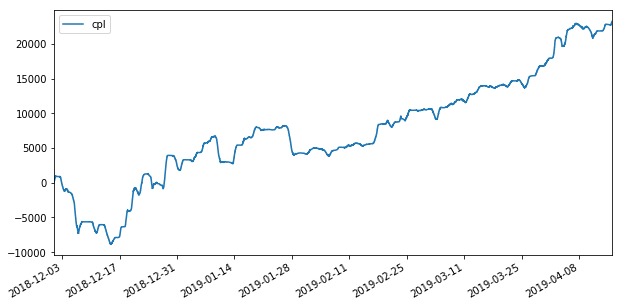

----------------
PnL with ML


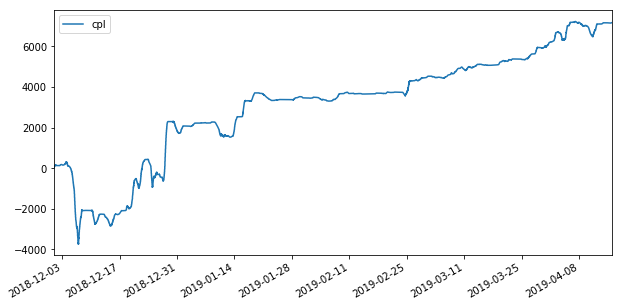

In [228]:

print('Original PnL - No ML')

test.plot(x=test.index,y='cpl',figsize=[10,5])
plt.show()
print('----------------')
print('PnL with ML')
trades.plot(x=trades.index,y='cpl',figsize=[10,5])
plt.show()

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Original PnL - No ML


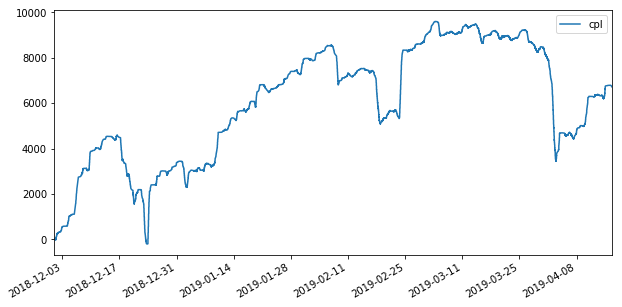

----------------
PnL with ML


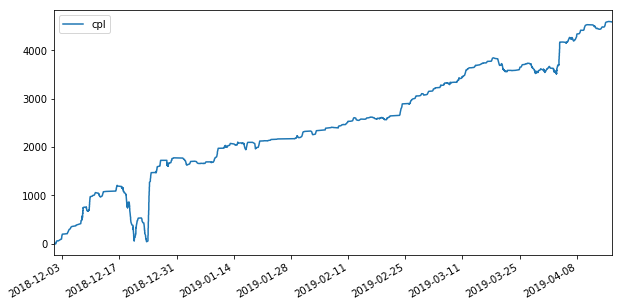

In [162]:
trades['cpl'] = trades.Pnl_Short.cumsum()

test['cpl'] = test.Pnl_Short.cumsum()
print('Original PnL - No ML')

test.plot(x=test.index,y='cpl',figsize=[10,5])
plt.show()
print('----------------')
print('PnL with ML')
trades.plot(x=trades.index,y='cpl',figsize=[10,5])
plt.show()

In [190]:
def divergence_v2(close,RSI,lookback,window,maxx,low):
    x=RSI.values
    peaks=argrelextrema(x, np.greater,order=5)[0]
    troughs=argrelextrema(x, np.less,order=5)[0]
    bear_rsi=[]
    bear_price=[]
    bull_rsi=[]
    bull_price=[]
    hid_bear_rsi=[]
    hid_bear_price=[]
    hid_bull_rsi=[]
    hid_bull_price=[]
    for x in peaks:    
        if RSI.iloc[x]>maxx:
            if RSI.iloc[x]<max(RSI.iloc[max(0,x-lookback):x]):
                bear_rsi.append(x)
            if close.iloc[x]>max(close.iloc[max(0,x-lookback):x]):
                bear_price.append(x)
            if RSI.iloc[x]>max(RSI.iloc[max(0,x-lookback):x]):
                hid_bear_rsi.append(x)
    
    for t in troughs:
        if RSI.iloc[t]<low:
            if close.iloc[t]<min(close.iloc[max(0,t-lookback):t]):
                bull_price.append(t)
            if RSI.iloc[t]<min(RSI.iloc[max(0,t-lookback):t]):
                hid_bull_rsi.append(t) 
    
    for z in range(1,len(troughs)):
        if RSI.iloc[troughs[z]]<low:
            if RSI.iloc[troughs[z]]>RSI.iloc[troughs[z-1]]:
                bull_rsi.append(troughs[z]) 
            if close.iloc[troughs[z]]>close.iloc[troughs[z-1]]:
                hid_bull_price.append(troughs[z]) 
    
    for t in range(1,len(peaks)):
        if RSI.iloc[peaks[t]]>maxx:
            if close.iloc[peaks[t]]<close.iloc[peaks[t-1]]:
                hid_bear_price.append(peaks[t]) 
            
    dt=set(bear_rsi)
    dt2=set(bear_price)
    dt3=set(bull_rsi)
    dt4=set(bull_price)
    dt5=set(hid_bull_rsi)
    dt6=set(hid_bull_price)
    dt7=set(hid_bear_rsi)
    dt8=set(hid_bear_price)
    mergedlist=dt.intersection(dt2)
    mergedlist=np.array(list(mergedlist))
    mergedlist2=dt3.intersection(dt4)
    mergedlist2=np.array(list(mergedlist2))
    mergedlist3=dt5.intersection(dt6)
    mergedlist3=np.array(list(mergedlist3))
    mergedlist4=dt7.intersection(dt8)
    mergedlist4=np.array(list(mergedlist4))
    bull_div=np.sort(mergedlist2)
    bear_div=np.sort(mergedlist)
    hid_bull_div=np.sort(mergedlist3)
    hid_bear_div=np.sort(mergedlist4)
    return bull_div,bear_div,hid_bull_div,hid_bear_div



In [342]:
from sklearn.model_selection import GridSearchCV

xgb = XGBClassifier()
n=np.arange(50,600,100)
md=np.arange(1,7)
nl=np.arange(10,20,10)
mln=np.arange(50,400,100)
lr=np.arange(.01,.2,.05)
hyperparam=dict(max_depth=md,N=n,num_leaves=nl,min_leaf_data=mln,eta=lr)
clf=GridSearchCV(xgb,hyperparam,cv=5,verbose=1)
best=clf.fit(X,Y)


Fitting 5 folds for each of 576 candidates, totalling 2880 fits


/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

KeyboardInterrupt: 